In [113]:
import numpy as np
import pandas as pd

import random
random.seed(28)
np.random.seed(28)

import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import os
import copy
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import time
from collections import Counter
import datetime
#from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
#import eli5
import shap
from IPython.display import HTML
import json

import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
pd.set_option('max_rows', 500)
import re

import os

pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 10000)
# pd.set_option('display.float_format', '{:20,.2f}'.format)
# pd.set_option('display.max_colwidth', -1)

from pylab import rcParams
rcParams['figure.figsize'] = 18,8

np.random.seed(2206)

# Read the data

In [2]:
train = pd.read_csv("data/training_v2.csv")
samplesubmission = pd.read_csv("data/samplesubmission.csv")
test = pd.read_csv("data/unlabeled.csv")
dictionary = pd.read_csv("data/WiDS Datathon 2020 Dictionary.csv")
solution_template = pd.read_csv("data/solution_template.csv")

print('train ' , train.shape)
print('test ' , test.shape)
print('samplesubmission ' , samplesubmission.shape)
print('solution_template ' , solution_template.shape)
print('dictionary ' , dictionary.shape)

train  (91713, 186)
test  (39308, 186)
samplesubmission  (3, 2)
solution_template  (39308, 2)
dictionary  (188, 6)


In [3]:
dico = pd.DataFrame(dictionary.T.head(6))
dico.columns=list(dico.loc[dico.index == 'Variable Name'].unstack())
dico = dico.loc[dico.index != 'Variable Name']
#dico.columns

train_stat = pd.DataFrame(train.describe())
train_stat2 = pd.concat([dico,train_stat],axis=0)
#train_stat2.head(20)

# Overview of the dataset

In [10]:
train_stat2.T.to_excel('data_describe.xlsx')
train_stat2

age                                                                                                                   aids                                                                                              albumin_apache                      apache_2_bodysystem                             apache_2_diagnosis                      apache_3j_bodysystem                                                                        apache_3j_diagnosis                                                                                                                                    apache_4a_hospital_death_prob                                                                                                                                   apache_4a_icu_death_prob                                                   apache_post_operative  \
Category         demographic                               APACHE comorbidity                                                                                                     APACHE covariate                                                                                            APACHE grouping                          APACHE covariate                               APACHE grouping                           APACHE covariate                                                                           APACHE prediction                                                                                                                                                APACHE prediction                                                                                                                                          APACHE covariate                                                         
Unit of Measure  Years                                     None                                                                                                                   g/L                                                                                                         None                                     None                                           None                                      None                                                                                       None                                                                                                                                                             None                                                                                                                                                       None                                                                     
Data Type        numeric                                   binary                                                                                                                 numeric                                                                                                     string                                   string                                         string                                    string                                                                                     numeric                                                                                                                                                          numeric                                                                                                                                                    binary                                                                   
Description      The age of the patient on unit admission  Whether the patient has a definitive diagnosis of acquired immune deficiency syndrome (AIDS) (not HIV positive alone)  The albumin concentration measured during the first 24 hours which results in the highest APACHE III score  Admission diagnosis group for APACHE II  The APACHE II diagnosis for the ICU admission  Admission diagnosis group for APACHE III  The APACHE III-J sub-diagnosis code which best des

In [15]:
# Missing Data proportion
pd.DataFrame(train.isnull().sum()/len(train)*100, columns=['prop']).sort_values(by='prop', ascending=False)

prop
h1_bilirubin_min                             92.27
h1_bilirubin_max                             92.27
h1_lactate_max                               91.99
h1_lactate_min                               91.99
h1_albumin_max                               91.40
h1_albumin_min                               91.40
h1_pao2fio2ratio_min                         87.44
h1_pao2fio2ratio_max                         87.44
h1_arterial_ph_max                           83.33
h1_arterial_ph_min                           83.33
h1_hco3_max                                  82.97
h1_hco3_min                                  82.97
h1_arterial_pco2_min                         82.82
h1_arterial_pco2_max                         82.82
h1_wbc_max                                   82.82
h1_wbc_min                                   82.82
h1_arterial_po2_max                          82.81
h1_arterial_po2_min                          82.81
h1_calcium_max                               82.72
h1_calcium_min                               82.72
h1_platelets_max                             82.51
h1_platelets_min                             82.51
h1_bun_max                                   81.88
h1_bun_min                                   81.88
h1_creatinine_max                            81.73
h1_creatinine_min                            81.73
h1_diasbp_invasive_min                       81.70
h1_diasbp_invasive_max                       81.70
h1_sysbp_invasive_max                        81.68
h1_sysbp_invasive_min                        81.68
h1_mbp_invasive_min                          81.61
h1_mbp_invasive_max                          81.61
h1_hematocrit_max                            80.05
h1_hematocrit_min                            80.05
h1_hemaglobin_min                            79.73
h1_hemaglobin_max                            79.73
h1_sodium_min                                79.18
h1_sodium_max                                79.18
h1_potassium_max                             78.62
h1_potassium_min                             78.62
pao2_apache                                  77.27
ph_apache                                    77.27
paco2_for_ph_apache                          77.27
paco2_apache                                 77.27
fio2_apache                                  77.27
d1_lactate_max                               74.58
d1_lactate_min                               74.58
d1_diasbp_invasive_min                       74.13
d1_diasbp_invasive_max                       74.13
d1_sysbp_invasive_min                        74.10
d1_sysbp_invasive_max                        74.10
d1_mbp_invasive_max                          73.90
d1_mbp_invasive_min                          73.90
d1_pao2fio2ratio_min                         71.97
d1_pao2fio2ratio_max                         71.97
d1_arterial_ph_max                           65.56
d1_arterial_ph_min                           65.56
d1_arterial_pco2_max                         64.63
d1_arterial_pco2_min                         64.63
d1_arterial_po2_min                          64.62
d1_arterial_po2_max                          64.62
bilirubin_apache                             63.39
h1_inr_max                                   63.18
h1_inr_min                                   63.18
d1_inr_min                                   63.18
d1_inr_max                                   63.18
albumin_apache                               59.29
d1_bilirubin_max                             58.52
d1_bilirubin_min                             58.52
h1_glucose_min                               57.37
h1_glucose_max                               57.37
d1_albumin_max                               53.53
d1_albumin_min                               53.53
urineoutput_apache                           53.43
wbc_apache                                   24.00
h1_temp_min                                  23.70
h1_temp_max                                  23.70
hospital_admit_source                        23.34
hematocrit_apache

### Target Variable = hospital_death

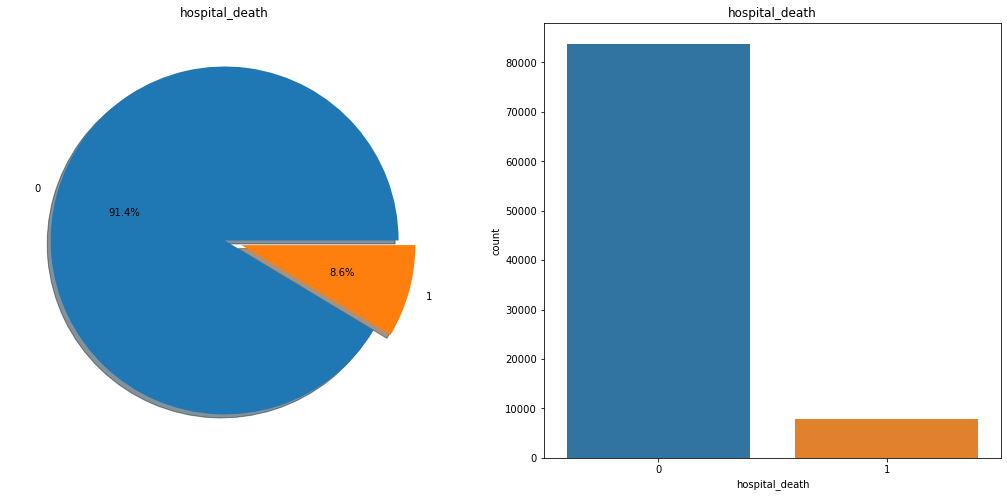

In [114]:
f,ax=plt.subplots(1,2)
train['hospital_death'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('hospital_death')
ax[0].set_ylabel('')

sns.countplot('hospital_death',data=train,ax=ax[1])
ax[1].set_title('hospital_death')

plt.show()

### Categorical Features

##### apache_2_bodysystem and apache_3j_bodysystem

In [29]:
train.groupby(['apache_2_bodysystem', 'apache_3j_bodysystem']).count()

encounter_id  patient_id  hospital_id  hospital_death    age    bmi  elective_surgery  ethnicity  gender  height  hospital_admit_source  icu_admit_source  icu_id  icu_stay_type  icu_type  pre_icu_los_days  readmission_status  weight  albumin_apache  apache_2_diagnosis  apache_3j_diagnosis  apache_post_operative  arf_apache  bilirubin_apache  bun_apache  creatinine_apache  fio2_apache  gcs_eyes_apache  gcs_motor_apache  gcs_unable_apache  gcs_verbal_apache  glucose_apache  heart_rate_apache  hematocrit_apache  intubated_apache  map_apache  paco2_apache  paco2_for_ph_apache  pao2_apache  ph_apache  resprate_apache  sodium_apache  temp_apache  urineoutput_apache  ventilated_apache  wbc_apache  d1_diasbp_invasive_max  d1_diasbp_invasive_min  d1_diasbp_max  d1_diasbp_min  d1_diasbp_noninvasive_max  d1_diasbp_noninvasive_min  d1_heartrate_max  d1_heartrate_min  d1_mbp_invasive_max  d1_mbp_invasive_min  d1_mbp_max  d1_mbp_min  \
apache_2_bodysystem apache_3j_bodysystem                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
Cardiovascular      Cardiovascular        27051         27051       27051        27051           26011  25966  27051             26559      27042   26642   20929                  27012             27051   27051          27051     27051             27051               26175   9395            27051               27051                27051                  27051       8421              20950       21139              5786         26737            26737             27009              26737              23555           27015              20782              27051             26982       5786          5786                 5786         5786       26850            21097          25847        13008               27051              20229       9550                    9550                    27003          27003          26516                      26516                      27023             27023             9605                 9605                 26999       26999        
                    Genitourinary         25            25          25           25              25     24     25                25         25      24      20                     24                25      25             25        25                25                  24      9               25                  25                   25                     25          8                 14          14                 0            25               25                25                 25                 14              25                 23                 25                25          0             0                    0            0          25               14             21           6                   25                 23          3                       3                       25             25             25                         25                         25                25                3                    3                    25          25           
                    Sepsis                11740         11740       11740        11740           11083  11368  11740             1

In [74]:
na_apache_2_bodysystem = train[train['apache_2_bodysystem'].isnull()].index.tolist()

na_apache_3j_bodysystem = train[train['apache_3j_bodysystem'].isnull()].index.tolist()

na_apache2and3j = train.iloc[na_apache_2_bodysystem+na_apache_3j_bodysystem][['apache_2_bodysystem', 'apache_3j_bodysystem']]

#set(na_apache_2_bodysystem+na_apache_3j_bodysystem)

#train.iloc[81931][['apache_2_bodysystem', 'apache_3j_bodysystem']]

na_apache2and3j

apache_2_bodysystem apache_3j_bodysystem
44     NaN                 NaN                
83     NaN                 NaN                
136    NaN                 NaN                
218    NaN                 NaN                
255    NaN                 NaN                
303    NaN                 NaN                
306    NaN                 NaN                
350    NaN                 NaN                
397    NaN                 NaN                
416    NaN                 NaN                
553    NaN                 NaN                
571    NaN                 NaN                
576    NaN                 NaN                
587    NaN                 NaN                
606    NaN                 NaN                
647    NaN                 NaN                
689    NaN                 NaN                
707    NaN                 NaN                
921    NaN                 NaN                
935    NaN                 NaN                
954    NaN                 NaN                
962    NaN                 NaN                
968    NaN                 NaN                
1019   NaN                 NaN                
1081   NaN                 NaN                
1104   NaN                 NaN                
1147   NaN                 NaN                
1154   NaN                 NaN                
1174   NaN                 NaN                
1188   NaN                 NaN                
1246   NaN                 NaN                
1287   NaN                 NaN                
1303   NaN                 NaN                
1315   NaN                 NaN                
1327   NaN                 NaN                
1437   NaN                 NaN                
1439   NaN                 NaN                
1490   NaN                 NaN                
1547   NaN                 NaN                
1573   NaN                 NaN                
1578   NaN                 NaN                
1653   NaN                 NaN                
1656   NaN                 NaN                
1657   NaN                 NaN                
1660   NaN                 NaN                
1667   NaN                 NaN                
1756   NaN                 NaN                
1807   NaN                 NaN                
1826   NaN                 NaN                
1874   NaN                 NaN                
1892   NaN                 NaN                
1961   NaN                 NaN                
1964   NaN                 NaN                
2073   NaN                 NaN                
2100   NaN                 NaN                
2138   NaN                 NaN                
2166   NaN                 NaN                
2300   NaN                 NaN                
2315   NaN                 NaN                
2328   NaN                 NaN                
2335   NaN                 NaN                
2409   NaN                 NaN                
2413   NaN                 NaN                
2476   NaN                 NaN                
2600   NaN                 NaN                
2615   NaN                 NaN                
2623   NaN                 NaN                
2628   NaN                 NaN                
2931   NaN                 NaN                
2939   NaN                 NaN                
2983   NaN                 NaN                
3011   NaN                 NaN                
3016   NaN                 NaN                
3038   NaN                 NaN                
3112   NaN                 NaN                
3164   NaN                 NaN                
3216   NaN                 NaN                
3236   NaN                 NaN                
3304   NaN                 NaN                
3357   NaN                 NaN                
3387   NaN                 NaN                
3437   NaN                 NaN                
3536   NaN                 NaN                
3548   NaN                 NaN                
3572   NaN 

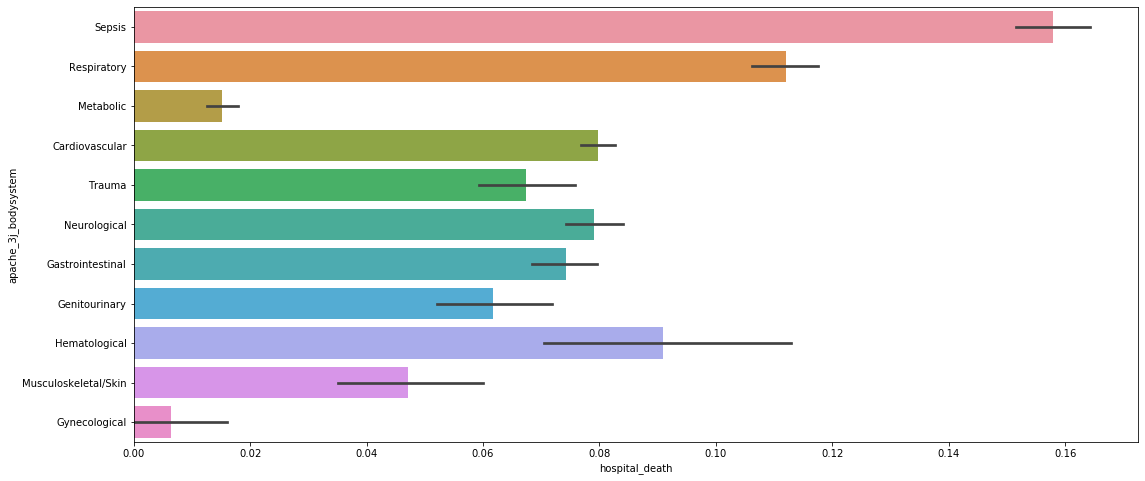

In [117]:
sns.barplot(y="apache_3j_bodysystem", x="hospital_death" , data=train);

##### apache_2_diagnosis and apache_2_diagnosis

In [135]:
train.groupby(['apache_2_diagnosis', 'apache_3j_diagnosis']).count()

encounter_id  patient_id  hospital_id  hospital_death   age   bmi  elective_surgery  ethnicity  gender  height  hospital_admit_source  icu_admit_source  icu_id  icu_stay_type  icu_type  pre_icu_los_days  readmission_status  weight  albumin_apache  apache_post_operative  arf_apache  bilirubin_apache  bun_apache  creatinine_apache  fio2_apache  gcs_eyes_apache  gcs_motor_apache  gcs_unable_apache  gcs_verbal_apache  glucose_apache  heart_rate_apache  hematocrit_apache  intubated_apache  map_apache  paco2_apache  paco2_for_ph_apache  pao2_apache  ph_apache  resprate_apache  sodium_apache  temp_apache  urineoutput_apache  ventilated_apache  wbc_apache  d1_diasbp_invasive_max  d1_diasbp_invasive_min  d1_diasbp_max  d1_diasbp_min  d1_diasbp_noninvasive_max  d1_diasbp_noninvasive_min  d1_heartrate_max  d1_heartrate_min  d1_mbp_invasive_max  d1_mbp_invasive_min  d1_mbp_max  d1_mbp_min  d1_mbp_noninvasive_max  d1_mbp_noninvasive_min  d1_resprate_max  d1_resprate_min  d1_spo2_max  d1_spo2_min  d1_sysbp_invasive_max  d1_sysbp_invasive_min  d1_sysbp_max  d1_sysbp_min  d1_sysbp_noninvasive_max  d1_sysbp_noninvasive_min  d1_temp_max  d1_temp_min  h1_diasbp_invasive_max  h1_diasbp_invasive_min  h1_diasbp_max  h1_diasbp_min  h1_diasbp_noninvasive_max  h1_diasbp_noninvasive_min  h1_heartrate_max  h1_heartrate_min  h1_mbp_invasive_max  h1_mbp_invasive_min  h1_mbp_max  h1_mbp_min  h1_mbp_noninvasive_max  h1_mbp_noninvasive_min  h1_resprate_max  h1_resprate_min  h1_spo2_max  h1_spo2_min  h1_sysbp_invasive_max  h1_sysbp_invasive_min  h1_sysbp_max  h1_sysbp_min  h1_sysbp_noninvasive_max  h1_sysbp_noninvasive_min  h1_temp_max  h1_temp_min  d1_albumin_max  d1_albumin_min  d1_bilirubin_max  d1_bilirubin_min  d1_bun_max  d1_bun_min  d1_calcium_max  d1_calcium_min  d1_creatinine_max  d1_creatinine_min  d1_glucose_max  d1_glucose_min  d1_hco3_max  d1_hco3_min  d1_hemaglobin_max  d1_hemaglobin_min  d1_hematocrit_max  d1_hematocrit_min  d1_inr_max  d1_inr_min  d1_lactate_max  d1_lactate_min  d1_platelets_max  d1_platelets_min  d1_potassium_max  d1_potassium_min  d1_sodium_max  d1_sodium_min  d1_wbc_max  d1_wbc_min  h1_albumin_max  h1_albumin_min  h1_bilirubin_max  h1_bilirubin_min  h1_bun_max  h1_bun_min  h1_calcium_max  h1_calcium_min  h1_creatinine_max  h1_creatinine_min  h1_glucose_max  h1_glucose_min  h1_hco3_max  h1_hco3_min  h1_hemaglobin_max  h1_hemaglobin_min  h1_hematocrit_max  h1_hematocrit_min  h1_inr_max  h1_inr_min  h1_lactate_max  h1_lactate_min  h1_platelets_max  h1_platelets_min  h1_potassium_max  h1_potassium_min  h1_sodium_max  h1_sodium_min  h1_wbc_max  h1_wbc_min  d1_arterial_pco2_max  d1_arterial_pco2_min  d1_arterial_ph_max  d1_arterial_ph_min  d1_arterial_po2_max  d1_arterial_po2_min  d1_pao2fio2ratio_max  d1_pao2fio2ratio_min  h1_arterial_pco2_max  h1_arterial_pco2_min  h1_arterial_ph_max  h1_arterial_ph_min  h1_arterial_po2_max  h1_arterial_po2_min  h1_pao2fio2ratio_max  h1_pao2fio2ratio_min  apache_4a_hospital_death_prob  apache_4a_icu_death_prob  aids  cirrhosis  diabetes_mellitus  hepatic_failure  immunosuppression  leukemia  lymphoma  solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem
apache_2_diagnosis apache_3j_diagnosis                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [137]:
train.groupby(['apache_3j_diagnosis', 'apache_2_diagnosis']).count()

encounter_id  patient_id  hospital_id  hospital_death   age   bmi  elective_surgery  ethnicity  gender  height  hospital_admit_source  icu_admit_source  icu_id  icu_stay_type  icu_type  pre_icu_los_days  readmission_status  weight  albumin_apache  apache_post_operative  arf_apache  bilirubin_apache  bun_apache  creatinine_apache  fio2_apache  gcs_eyes_apache  gcs_motor_apache  gcs_unable_apache  gcs_verbal_apache  glucose_apache  heart_rate_apache  hematocrit_apache  intubated_apache  map_apache  paco2_apache  paco2_for_ph_apache  pao2_apache  ph_apache  resprate_apache  sodium_apache  temp_apache  urineoutput_apache  ventilated_apache  wbc_apache  d1_diasbp_invasive_max  d1_diasbp_invasive_min  d1_diasbp_max  d1_diasbp_min  d1_diasbp_noninvasive_max  d1_diasbp_noninvasive_min  d1_heartrate_max  d1_heartrate_min  d1_mbp_invasive_max  d1_mbp_invasive_min  d1_mbp_max  d1_mbp_min  d1_mbp_noninvasive_max  d1_mbp_noninvasive_min  d1_resprate_max  d1_resprate_min  d1_spo2_max  d1_spo2_min  d1_sysbp_invasive_max  d1_sysbp_invasive_min  d1_sysbp_max  d1_sysbp_min  d1_sysbp_noninvasive_max  d1_sysbp_noninvasive_min  d1_temp_max  d1_temp_min  h1_diasbp_invasive_max  h1_diasbp_invasive_min  h1_diasbp_max  h1_diasbp_min  h1_diasbp_noninvasive_max  h1_diasbp_noninvasive_min  h1_heartrate_max  h1_heartrate_min  h1_mbp_invasive_max  h1_mbp_invasive_min  h1_mbp_max  h1_mbp_min  h1_mbp_noninvasive_max  h1_mbp_noninvasive_min  h1_resprate_max  h1_resprate_min  h1_spo2_max  h1_spo2_min  h1_sysbp_invasive_max  h1_sysbp_invasive_min  h1_sysbp_max  h1_sysbp_min  h1_sysbp_noninvasive_max  h1_sysbp_noninvasive_min  h1_temp_max  h1_temp_min  d1_albumin_max  d1_albumin_min  d1_bilirubin_max  d1_bilirubin_min  d1_bun_max  d1_bun_min  d1_calcium_max  d1_calcium_min  d1_creatinine_max  d1_creatinine_min  d1_glucose_max  d1_glucose_min  d1_hco3_max  d1_hco3_min  d1_hemaglobin_max  d1_hemaglobin_min  d1_hematocrit_max  d1_hematocrit_min  d1_inr_max  d1_inr_min  d1_lactate_max  d1_lactate_min  d1_platelets_max  d1_platelets_min  d1_potassium_max  d1_potassium_min  d1_sodium_max  d1_sodium_min  d1_wbc_max  d1_wbc_min  h1_albumin_max  h1_albumin_min  h1_bilirubin_max  h1_bilirubin_min  h1_bun_max  h1_bun_min  h1_calcium_max  h1_calcium_min  h1_creatinine_max  h1_creatinine_min  h1_glucose_max  h1_glucose_min  h1_hco3_max  h1_hco3_min  h1_hemaglobin_max  h1_hemaglobin_min  h1_hematocrit_max  h1_hematocrit_min  h1_inr_max  h1_inr_min  h1_lactate_max  h1_lactate_min  h1_platelets_max  h1_platelets_min  h1_potassium_max  h1_potassium_min  h1_sodium_max  h1_sodium_min  h1_wbc_max  h1_wbc_min  d1_arterial_pco2_max  d1_arterial_pco2_min  d1_arterial_ph_max  d1_arterial_ph_min  d1_arterial_po2_max  d1_arterial_po2_min  d1_pao2fio2ratio_max  d1_pao2fio2ratio_min  h1_arterial_pco2_max  h1_arterial_pco2_min  h1_arterial_ph_max  h1_arterial_ph_min  h1_arterial_po2_max  h1_arterial_po2_min  h1_pao2fio2ratio_max  h1_pao2fio2ratio_min  apache_4a_hospital_death_prob  apache_4a_icu_death_prob  aids  cirrhosis  diabetes_mellitus  hepatic_failure  immunosuppression  leukemia  lymphoma  solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem
apache_3j_diagnosis apache_2_diagnosis                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [136]:
na_apache_2_diagnosis = train[train['apache_2_diagnosis'].isnull()].index.tolist()

na_apache_3j_diagnosis = train[train['apache_3j_diagnosis'].isnull()].index.tolist()

na_apache2and3j_diagnosis = train.iloc[na_apache_2_diagnosis+na_apache_3j_diagnosis][['apache_2_diagnosis', 'apache_3j_diagnosis']]

#set(na_apache_2_bodysystem+na_apache_3j_bodysystem)

#train.iloc[81931][['apache_2_bodysystem', 'apache_3j_bodysystem']]

na_apache2and3j_diagnosis

apache_2_diagnosis  apache_3j_diagnosis
44                     nan                 0.25
83                     nan                 0.25
136                    nan                 0.11
218                    nan                 0.25
255                    nan                 0.25
303                    nan                 0.25
306                    nan                 0.25
350                    nan                  nan
397                    nan                  nan
416                    nan                 0.25
553                    nan                  nan
571                    nan                 0.25
576                    nan                  nan
587                    nan                 0.25
606                    nan                 0.25
647                    nan                  nan
689                    nan                  nan
707                    nan                  nan
921                    nan                 0.25
935                    nan                 0.25
954                    nan                  nan
962                    nan                  nan
968                    nan                  nan
1019                   nan                 0.18
1081                   nan                 0.11
1104                   nan                  nan
1147                   nan                 0.25
1154                   nan                 0.25
1174                   nan                 0.25
1188                   nan                  nan
1246                   nan                  nan
1287                   nan                 0.25
1303                   nan                 0.25
1315                   nan                 0.04
1327                   nan                  nan
1437                   nan                 0.22
1439                   nan                 0.25
1490                   nan                 0.23
1547                   nan                 0.22
1573                   nan                 0.25
1578                   nan                 0.25
1653                   nan                 0.25
1656                   nan                 0.22
1657                   nan                 0.25
1660                   nan                  nan
1667                   nan                  nan
1756                   nan                  nan
1807                   nan                 0.24
1826                   nan                 0.25
1874                   nan                 0.25
1892                   nan                  nan
1961                   nan                  nan
1964                   nan                  nan
2073                   nan                  nan
2100                   nan                  nan
2138                   nan                 0.25
2166                   nan                  nan
2300                   nan                  nan
2315                   nan                  nan
2328                   nan                 0.25
2335                   nan                 0.23
2409                   nan                 0.25
2413                   nan                 0.25
2476                   nan                  nan
2600                   nan                  nan
2615                   nan                 0.25
2623                   nan                  nan
2628                   nan                  nan
2931                   nan                  nan
2939                   nan                 0.25
2983                   nan                 0.25
3011                   nan                  nan
3016                   nan                 0.25
3038                   nan                  nan
3112                   nan                 0.25
3164                   nan                 0.25
3216                   nan                  nan
3236                   nan                  nan
3304                   nan                  nan
3357                   nan                 0.25
3387                   nan                 0.25
3437                   nan                 0.25
3536                   n

##### gender

In [119]:
train["gender"].value_counts()

M    49469
F    42219
Name: gender, dtype: int64

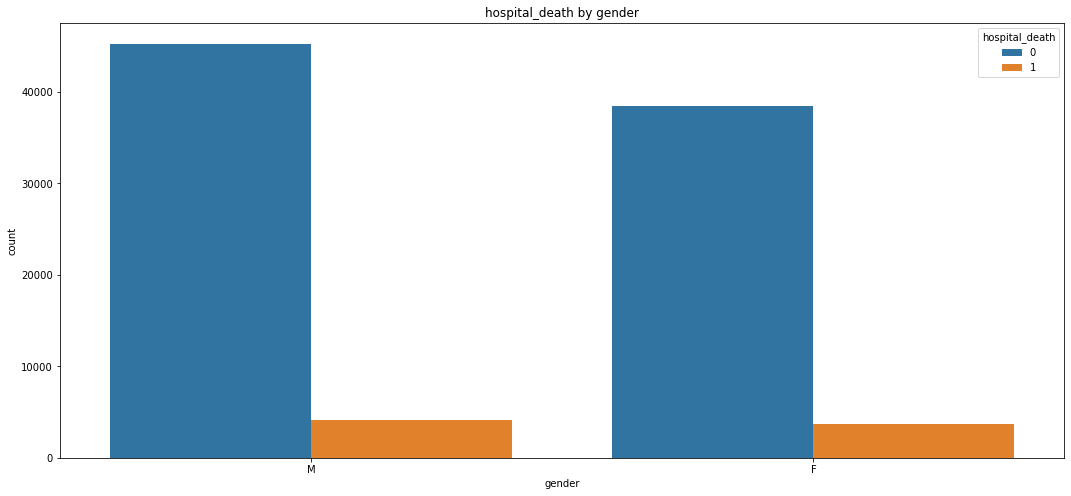

In [115]:
sns.countplot(data = train, x = 'gender',hue ='hospital_death')
plt.title('hospital_death by gender')
plt.show()

##### ethnicity 

In [118]:
train["ethnicity"].value_counts()

Caucasian           70684
African American    9547 
Other/Unknown       4374 
Hispanic            3796 
Asian               1129 
Native American     788  
Name: ethnicity, dtype: int64

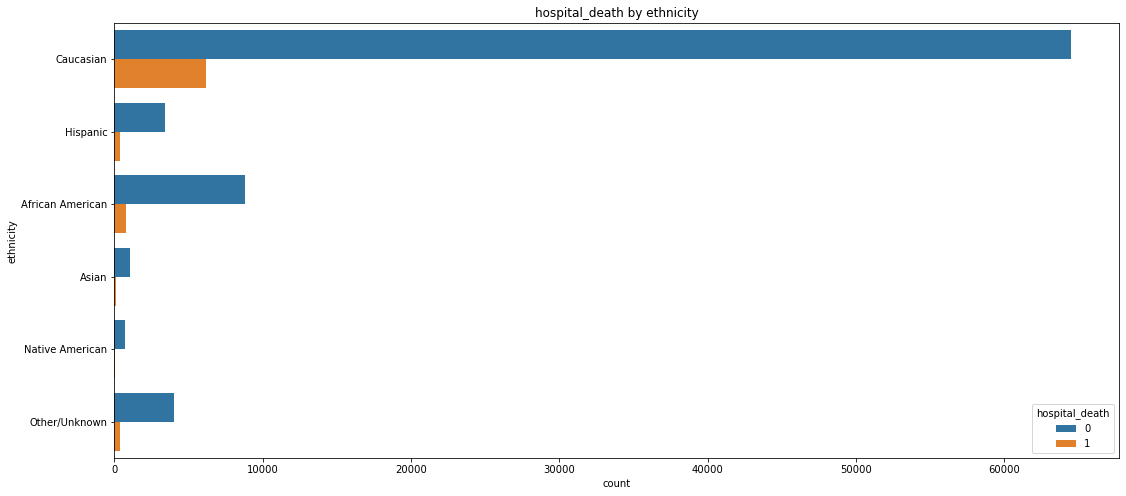

In [116]:
sns.countplot(y="ethnicity", hue="hospital_death" , data=train)
plt.title('hospital_death by ethnicity')
plt.show()

#### hospital_admit_source

In [120]:
train["hospital_admit_source"].value_counts()

Emergency Department    36962
Operating Room          9787 
Floor                   8055 
Direct Admit            6441 
Recovery Room           2896 
Acute Care/Floor        1910 
Other Hospital          1641 
Step-Down Unit (SDU)    1131 
PACU                    1017 
Other ICU               233  
Chest Pain Center       134  
ICU to SDU              45   
ICU                     35   
Observation             10   
Other                   7    
Name: hospital_admit_source, dtype: int64

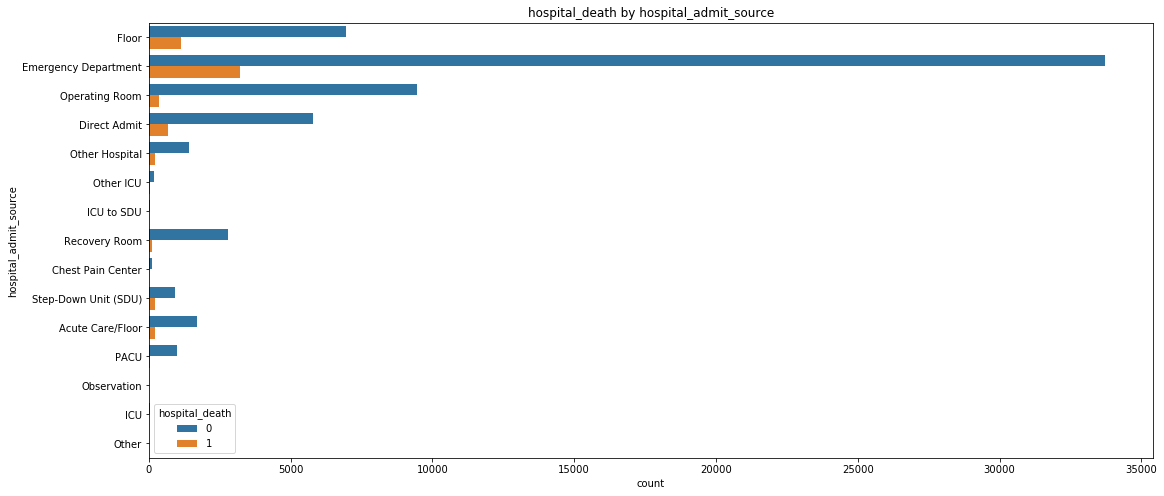

In [121]:
sns.countplot(y="hospital_admit_source", hue="hospital_death" , data=train)
plt.title('hospital_death by hospital_admit_source')
plt.show()

#### icu_admit_type

In [130]:
train["icu_stay_type"].value_counts()

admit       86183
transfer    4970 
readmit     560  
Name: icu_stay_type, dtype: int64

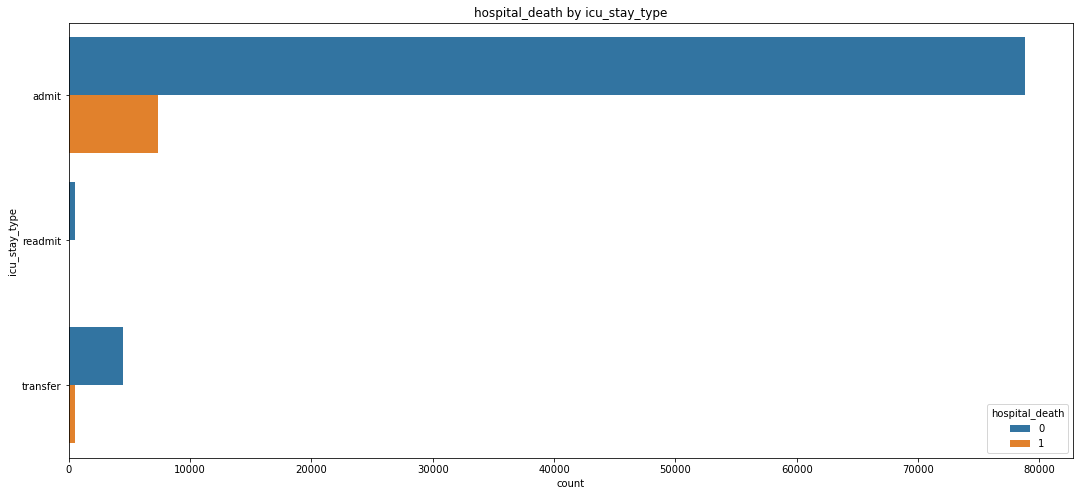

In [131]:
sns.countplot(y="icu_stay_type", hue="hospital_death" , data=train)
plt.title('hospital_death by icu_stay_type')
plt.show()

#### icu_type

In [132]:
train["icu_type"].value_counts()

Med-Surg ICU    50586
MICU            7695 
Neuro ICU       7675 
CCU-CTICU       7156 
SICU            5209 
Cardiac ICU     4776 
CSICU           4613 
CTICU           4003 
Name: icu_type, dtype: int64

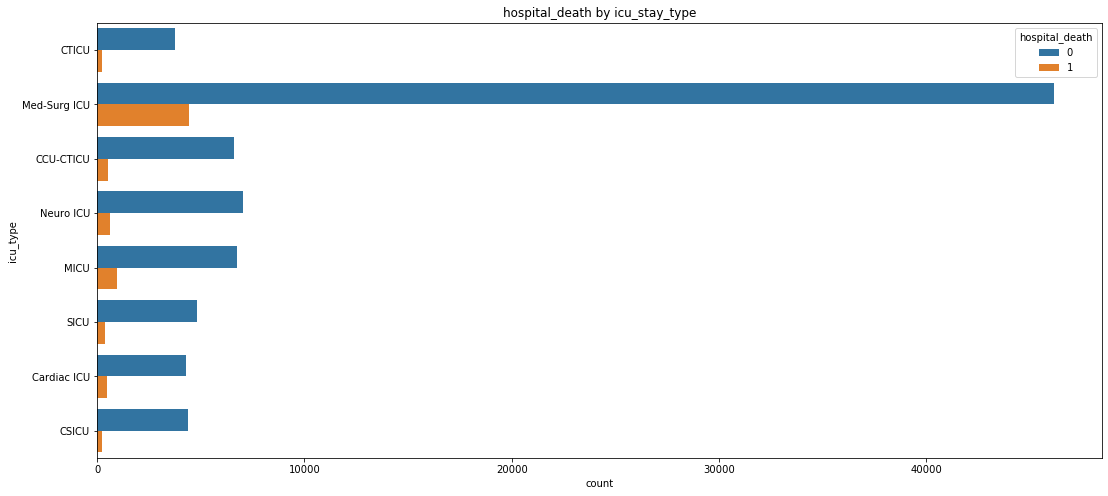

In [133]:
sns.countplot(y="icu_type", hue="hospital_death" , data=train)
plt.title('hospital_death by icu_stay_type')
plt.show()

In [134]:
train.groupby(['apache_2_bodysystem', 'apache_3j_bodysystem', 'icu_type']).count()

encounter_id  patient_id  hospital_id  hospital_death    age    bmi  elective_surgery  ethnicity  gender  height  hospital_admit_source  icu_admit_source  icu_id  icu_stay_type  pre_icu_los_days  readmission_status  weight  albumin_apache  apache_2_diagnosis  apache_3j_diagnosis  apache_post_operative  arf_apache  bilirubin_apache  bun_apache  creatinine_apache  fio2_apache  gcs_eyes_apache  gcs_motor_apache  gcs_unable_apache  gcs_verbal_apache  glucose_apache  heart_rate_apache  hematocrit_apache  intubated_apache  map_apache  paco2_apache  paco2_for_ph_apache  pao2_apache  ph_apache  resprate_apache  sodium_apache  temp_apache  urineoutput_apache  ventilated_apache  wbc_apache  d1_diasbp_invasive_max  d1_diasbp_invasive_min  d1_diasbp_max  d1_diasbp_min  d1_diasbp_noninvasive_max  d1_diasbp_noninvasive_min  d1_heartrate_max  d1_heartrate_min  d1_mbp_invasive_max  d1_mbp_invasive_min  d1_mbp_max  d1_mbp_min  d1_mbp_noninvasive_max  d1_mbp_noninvasive_min  d1_resprate_max  d1_resprate_min  d1_spo2_max  d1_spo2_min  d1_sysbp_invasive_max  d1_sysbp_invasive_min  d1_sysbp_max  d1_sysbp_min  d1_sysbp_noninvasive_max  d1_sysbp_noninvasive_min  d1_temp_max  d1_temp_min  h1_diasbp_invasive_max  h1_diasbp_invasive_min  h1_diasbp_max  h1_diasbp_min  h1_diasbp_noninvasive_max  h1_diasbp_noninvasive_min  h1_heartrate_max  h1_heartrate_min  h1_mbp_invasive_max  h1_mbp_invasive_min  h1_mbp_max  h1_mbp_min  h1_mbp_noninvasive_max  h1_mbp_noninvasive_min  h1_resprate_max  h1_resprate_min  h1_spo2_max  h1_spo2_min  h1_sysbp_invasive_max  h1_sysbp_invasive_min  h1_sysbp_max  h1_sysbp_min  h1_sysbp_noninvasive_max  h1_sysbp_noninvasive_min  h1_temp_max  h1_temp_min  d1_albumin_max  d1_albumin_min  d1_bilirubin_max  d1_bilirubin_min  d1_bun_max  d1_bun_min  d1_calcium_max  d1_calcium_min  d1_creatinine_max  d1_creatinine_min  d1_glucose_max  d1_glucose_min  d1_hco3_max  d1_hco3_min  d1_hemaglobin_max  d1_hemaglobin_min  d1_hematocrit_max  d1_hematocrit_min  d1_inr_max  d1_inr_min  d1_lactate_max  d1_lactate_min  d1_platelets_max  d1_platelets_min  d1_potassium_max  d1_potassium_min  d1_sodium_max  d1_sodium_min  d1_wbc_max  d1_wbc_min  h1_albumin_max  h1_albumin_min  h1_bilirubin_max  h1_bilirubin_min  h1_bun_max  h1_bun_min  h1_calcium_max  h1_calcium_min  h1_creatinine_max  h1_creatinine_min  h1_glucose_max  h1_glucose_min  h1_hco3_max  h1_hco3_min  h1_hemaglobin_max  h1_hemaglobin_min  h1_hematocrit_max  h1_hematocrit_min  h1_inr_max  h1_inr_min  h1_lactate_max  h1_lactate_min  h1_platelets_max  h1_platelets_min  h1_potassium_max  h1_potassium_min  h1_sodium_max  h1_sodium_min  h1_wbc_max  h1_wbc_min  d1_arterial_pco2_max  d1_arterial_pco2_min  d1_arterial_ph_max  d1_arterial_ph_min  d1_arterial_po2_max  d1_arterial_po2_min  d1_pao2fio2ratio_max  d1_pao2fio2ratio_min  h1_arterial_pco2_max  h1_arterial_pco2_min  h1_arterial_ph_max  h1_arterial_ph_min  h1_arterial_po2_max  h1_arterial_po2_min  h1_pao2fio2ratio_max  h1_pao2fio2ratio_min  apache_4a_hospital_death_prob  apache_4a_icu_death_prob   aids  cirrhosis  diabetes_mellitus  hepatic_failure  immunosuppression  leukemia  lymphoma  solid_tumor_with_metastasis
apache_2_bodysystem apache_3j_bodysystem icu_type                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

### Binary Features 

In [144]:
display(train["aids"].value_counts())

0.00    90920
1.00    78   
Name: aids, dtype: int64

0    73269
1    18444
Name: apache_post_operative, dtype: int64

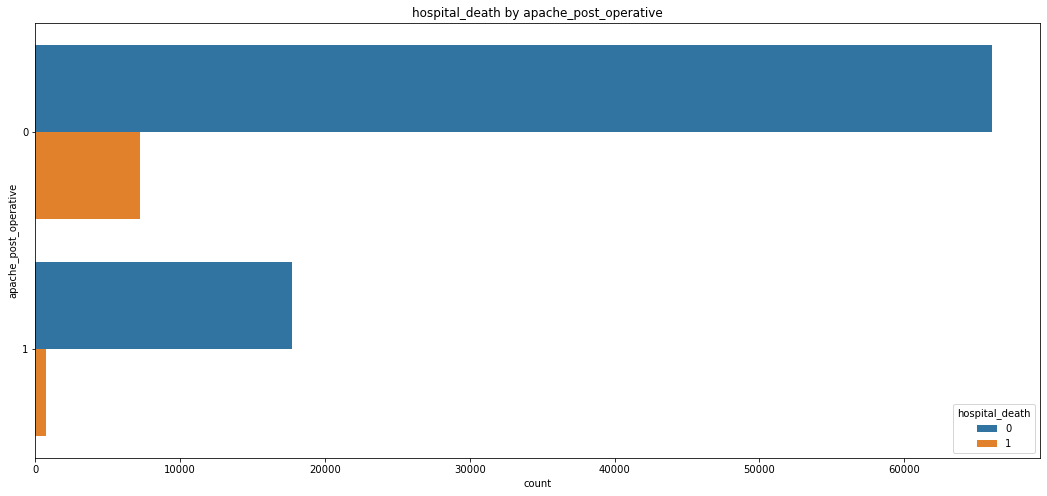

In [140]:
display(train["apache_post_operative"].value_counts())

sns.countplot(y="apache_post_operative", hue="hospital_death" , data=train)
plt.title('hospital_death by apache_post_operative')
plt.show()

# Useful Functions

In [17]:
# function to evaluate the score of our model
def eval_auc(pred,real):
    false_positive_rate, recall, thresholds = roc_curve(real, pred)
    roc_auc = auc(false_positive_rate, recall)
    return roc_auc    

In [18]:
# a wrapper class  that we can have the same ouput whatever the model we choose
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True,ps={}):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'hospital_death'
        self.cv = self.get_cv()
        self.verbose = verbose
#         self.params = self.get_params()
        self.params = self.set_params(ps)
        self.y_pred, self.score, self.model , self.oof_pred = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits

            print('Partial score of fold {} is: {}'.format(fold,eval_auc(oof_pred[val_idx],y_val) ))
        #print(oof_pred, self.train_df[self.target].values)
        loss_score = eval_auc(oof_pred,self.train_df[self.target].values) 
        if self.verbose:
            print('Our oof AUC score is: ', loss_score)
        return y_pred, loss_score, model , oof_pred

In [ ]:
#we choose to try a LightGbM using the Base_Model class
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set   = lgb.Dataset(x_val,    y_val,  categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.1,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100,
                    #'is_unbalance' : True ,
                    'scale_pos_weight' : 3
                  
                    }
        return params
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['scale_pos_weight']=ps['scale_pos_weight']
            params['max_depth']=int(ps['max_depth'])
        
        return params  

# Pre-Processing

In [ ]:
# Upper Case in String Features
uppercase_features = ['apache_2_bodysystem', 'apache_3j_bodysystem']
 
#train[uppercase_features] = train[uppercase_features].str.upper() 

train['apache_3j_bodysystem'].value_counts()

In [ ]:
#we are going to drop these columns because we dont want our ML model to be bias toward these consideration
#(we also remove the target and the ids.)
to_drop = ['gender','ethnicity' ,'encounter_id', 'patient_id',  'hospital_death']

# this is a list of features that look like to be categorical
categoricals_features = ['hospital_id','ethnicity','gender','hospital_admit_source','icu_admit_source',
                         'icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']
categoricals_features = [col for col in categoricals_features if col not in to_drop]

# this is the list of all input feature we would like our model to use 
features = [col for col in train.columns if col not in to_drop ]
print('numerber of features ' , len(features))
print('shape of train / test ', train.shape , test.shape)

categorical feature need to be transform to numeric for mathematical purpose.
different technics of categorical encoding exists here we will rely on our model API to deal with categorical
still we need to encode each categorical value to an id , for this purpose we use LabelEncoder


In [ ]:
# categorical feature need to be transform to numeric for mathematical purpose.
# different technics of categorical encoding exists here we will rely on our model API to deal with categorical
# still we need to encode each categorical value to an id , for this purpose we use LabelEncoder

print('Transform all String features to category.\n')
for usecol in categoricals_features:
    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1
    
    train[usecol] = train[usecol].replace(np.nan, 0).astype('int').astype('category')
    test[usecol]  = test[usecol].replace(np.nan, 0).astype('int').astype('category')

# Modele

In [ ]:
# percentage of death , hopefully it s a bit unbalanced
train['hospital_death'].sum()/train['hospital_death'].count()

# Hyper parameter tuning

In [ ]:
def LGB_Beyes(subsample_freq,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2,
                    scale_pos_weight):
    params={}
    params['subsample_freq']=subsample_freq
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    params['scale_pos_weight']=scale_pos_weight
    
    lgb_model= Lgb_Model(train, test, features, categoricals=categoricals_features,ps=params)
    print('auc: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'subsample_freq': (1, 10),
    'learning_rate': (0.005, 0.02),
    'feature_fraction': (0.5, 1),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 5),
    'max_depth': (13, 17),
    'scale_pos_weight': (1, 10),
}

# ACTIVATE it if you want to search for better parameter
if 0 : 
    LGB_BO = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
    import warnings
    init_points = 16
    n_iter = 16
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

In [ ]:
params = {'feature_fraction': 0.9,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'learning_rate': 0.1,
 'max_depth': 13,
 'subsample_freq': 1,
 'scale_pos_weight':1}

In [ ]:
lgb_model = Lgb_Model(train,test, features, categoricals=categoricals_features, ps=params)

Feature Importance from the lightgbm model (gain)

In [ ]:
imp_df = pd.DataFrame()
imp_df['feature'] = features
imp_df['gain']  = lgb_model.model.feature_importance(importance_type='gain')
imp_df['split'] = lgb_model.model.feature_importance(importance_type='split')

In [ ]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

In [ ]:
plot_importances(imp_df)

# Feature Importance by permutation importance algo

In [ ]:
import shap
explainer   =  shap.TreeExplainer(lgb_model.model)
shap_values = explainer.shap_values(train[features].iloc[:1000,:])
shap.summary_plot(shap_values, train[features].iloc[:1000,:])

# Some univariate plot of the best feature

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
i=0
for index, row in imp_df.sort_values(by=['gain'],ascending=False).iterrows():  
    column=row['feature']
    if i< 50:
            print(column,i,"gain :",row['gain'])
            df1      = train.loc[train['hospital_death']==0]
            df2      = train.loc[train['hospital_death']==1]

            fig = plt.figure(figsize=(20,4))
            sns.distplot(df1[column].dropna(),  color='red', label='hospital_death 0', kde=True); 
            sns.distplot(df2[column].dropna(),  color='blue', label='hospital_death 1', kde=True); 
            fig=plt.legend(loc='best')
            plt.xlabel(column, fontsize=12);
            plt.show()
            i=i+1


In [ ]:
test["hospital_death"] = lgb_model.y_pred
test[["encounter_id","hospital_death"]].to_csv("submission1.csv",index=False)